In [1]:
from torchvision.transforms import Compose, Resize, Normalize, ToTensor, Grayscale
from torchvision.transforms import RandomHorizontalFlip, RandomRotation
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision.transforms.functional import to_pil_image
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [2]:
# Transformations for training dataset (with data augmentation)
train_transform = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(),
    RandomRotation(10),
    Grayscale(num_output_channels=1),
    ToTensor(),
    Normalize(mean=[0.485], std=[0.229]),
])

# Transformations for test and validation datasets (without data augmentation)
test_val_transform = Compose([
    Resize((224, 224)),
    Grayscale(num_output_channels=1),
    ToTensor(),
    Normalize(mean=[0.485], std=[0.229]),
])

# Load the datasets
train_dataset = ImageFolder('C:/Users/LENOVO/Desktop/Production Project/chest_xray/train', transform=train_transform)
val_dataset = ImageFolder('C:/Users/LENOVO/Desktop/Production Project/chest_xray/val', transform=test_val_transform)
test_dataset = ImageFolder('C:/Users/LENOVO/Desktop/Production Project/chest_xray/test', transform=test_val_transform)

# Print the number of samples in each dataset
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 5230
Number of testing samples: 624
Number of validation samples: 29


In [3]:
batch_size = 200

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Random Normal Images:


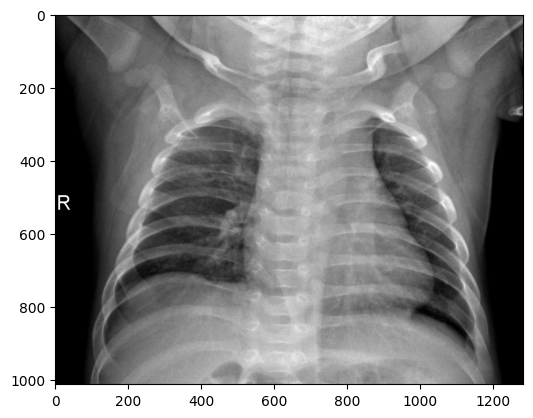

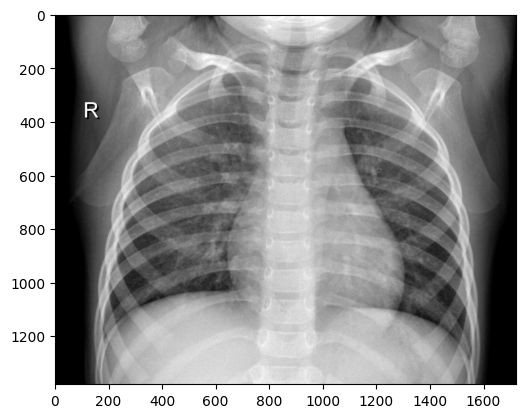

Random Pneumonia Images:


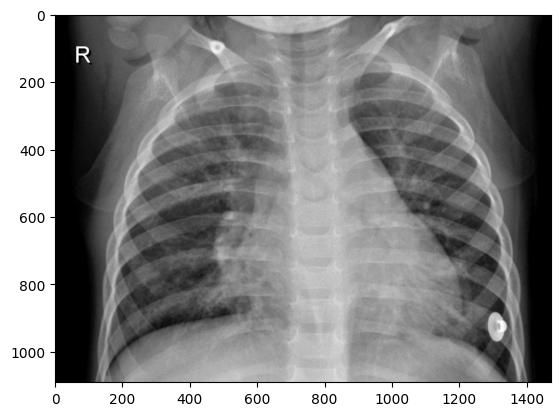

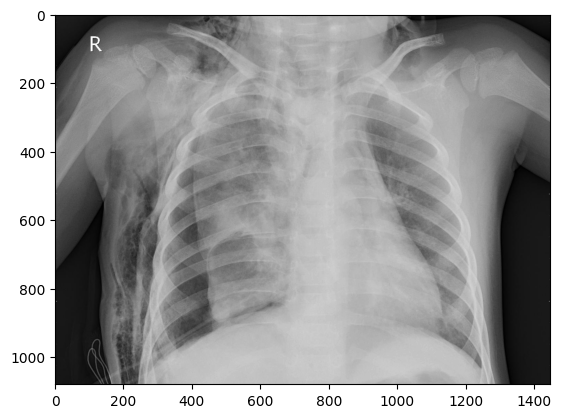

In [5]:
# Load the dataset without any transformations to access the original images
dataset_path = 'C:/Users/LENOVO/Desktop/Production Project/chest_xray/train'  # Adjust path as necessary
original_dataset = ImageFolder(dataset_path)

# Assuming the classes are named 'NORMAL' and 'PNEUMONIA' and are organized in separate folders
normal_indices = [i for i, label in enumerate(original_dataset.targets) if original_dataset.classes[label] == 'NORMAL']
pneumonia_indices = [i for i, label in enumerate(original_dataset.targets) if original_dataset.classes[label] == 'PNEUMONIA']

# Randomly select two indices for each class
normal_to_display = random.sample(normal_indices, 2)
pneumonia_to_display = random.sample(pneumonia_indices, 2)

# Function to display images
def show_images(indices):
    for index in indices:
        img_path = original_dataset.imgs[index][0]
        img = Image.open(img_path)
        plt.imshow(img, cmap='gray')
        plt.show()

# Display images
print("Random Normal Images:")
show_images(normal_to_display)

print("Random Pneumonia Images:")
show_images(pneumonia_to_display)

Random Transformed Normal Images:
Image size: (224, 224)


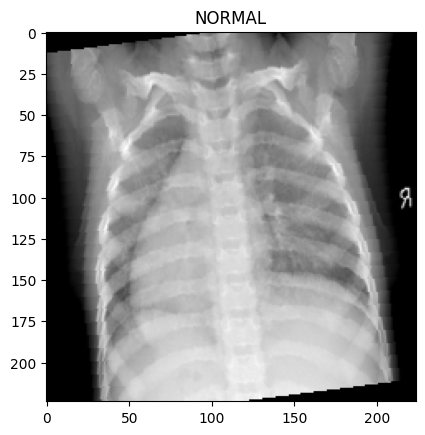

Image size: (224, 224)


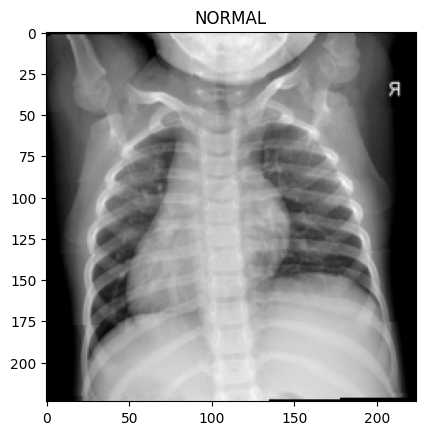

Random Transformed Pneumonia Images:
Image size: (224, 224)


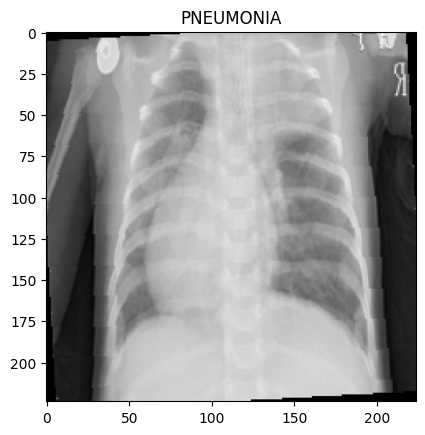

Image size: (224, 224)


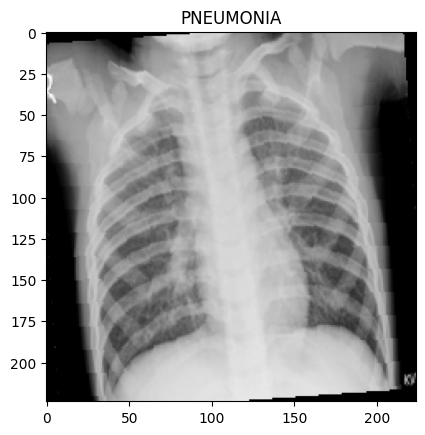

In [6]:

def show_transformed_images(indices, dataset):
    # Define the inverse normalization operation
    inverse_normalize = lambda x: x * torch.tensor([0.229])[:, None, None] + torch.tensor([0.485])[:, None, None]
    
    for index in indices:
        img_tensor, label = dataset[index]
        
        # Apply inverse normalization
        img_tensor = inverse_normalize(img_tensor)
        
        # Convert the tensor to a PIL image
        img = to_pil_image(img_tensor)
        
        # Print the size of the image
        print(f"Image size: {img.size}")
        
        # Display the image
        plt.imshow(img, cmap='gray')
        plt.title(dataset.classes[label])
        plt.show()

# Assuming normal_indices, pneumonia_indices, and train_dataset are defined elsewhere
transformed_normal_indices = random.sample(normal_indices, 2)
transformed_pneumonia_indices = random.sample(pneumonia_indices, 2)

print("Random Transformed Normal Images:")
show_transformed_images(transformed_normal_indices, train_dataset)

print("Random Transformed Pneumonia Images:")
show_transformed_images(transformed_pneumonia_indices, train_dataset)

In [16]:
class CNNModel(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(12544, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        
        # Activation
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout(x)  # Apply dropout after pooling
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout(x)  # Apply dropout after pooling
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout(x)  # Apply dropout after pooling
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout before final layers
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout before final layers
        x = self.sigmoid(self.fc3(x))
        return x

In [17]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

        if self.early_stop and self.verbose:
            print("Early stopping triggered")

In [18]:
torch.cuda.empty_cache()

In [19]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
# Loss function and optimizer

# Initialize early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

criteria = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize the StepLR scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Number of epochs
num_epochs = 10

best_val_loss = float('inf')



# Define the validate_model function before the training loop
def validate_model(model, val_loader, criteria, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criteria(outputs.squeeze(), labels.float())
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    print(f'Validation Loss: {avg_val_loss:.4f}')
    return avg_val_loss  # Return the average validation loss


# Training loop
total_batches = len(train_loader)
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criteria(outputs.squeeze(), labels.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print current batch number and learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
    # Update the learning rate
    scheduler.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}] completed. Loss: {running_loss/total_batches:.4f}. LR: {current_lr:.4f}')
    avg_val_loss = validate_model(model, val_loader, criteria, device)

    # Check if the current model is the best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved new best model")
        
        # Save the new best metric to a text file
        with open('best_metric.txt', 'w') as f:
            f.write(f'Best Validation Loss: {best_val_loss:.4f}')
        
        print(f"Saved new best metric: {best_val_loss:.4f} to best_metric.txt")
    
    # Early stopping check
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break  # Break out of the loop if early stopping is triggered

print('Finished Training')

KeyboardInterrupt: 

Test Loss: 0.4337, Accuracy: 0.8029, Precision: 0.8232, Recall: 0.8718, F1 Score: 0.8468
AUC: 0.7799


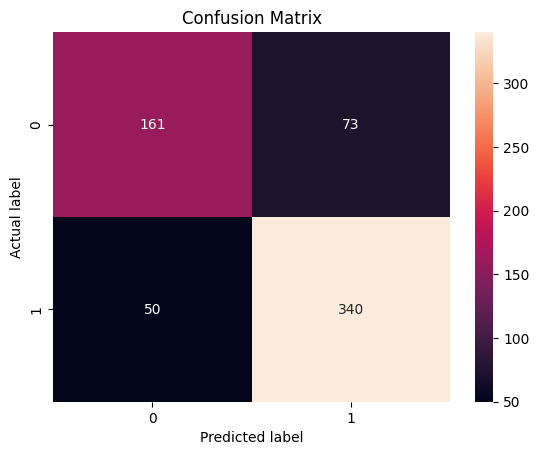

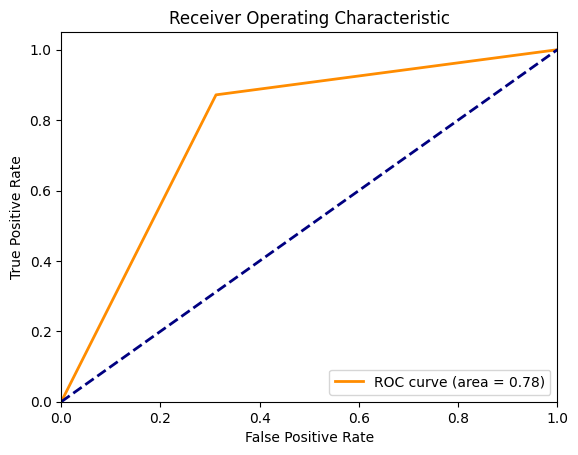

In [20]:
def evaluate_on_test_set(model, test_loader, criteria, device):
    model.eval()
    all_labels = []
    all_predictions = []
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criteria(outputs.squeeze(), labels.float())
            test_loss += loss.item()
            predictions = outputs.squeeze().round()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
    
    # Compute metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Call the function to evaluate the model on the test set
evaluate_on_test_set(model, test_loader, criteria, device)

In [25]:
model = CNNModel().to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

transform = Compose([
    Resize((224, 224)),
    Grayscale(num_output_channels=1),
    ToTensor(),
    Normalize(mean=[0.485], std=[0.229]),
])


image_path = "C:\\Users\\LENOVO\\Desktop\\monai project 2.0\\chest_xray\\images\\00013776_000.png"  
image = Image.open(image_path)
image = transform(image)
image = image.unsqueeze(0) 
image = image.to(device)

# Make a prediction
with torch.no_grad():
    prediction = model(image)
    predicted_label = prediction.item() > 0.5  # Adjust the threshold if necessary

# Print the result
if predicted_label:
    print("The image is predicted to have pneumonia.")
else:
    print("The image is predicted to not have pneumonia.")

The image is predicted to not have pneumonia.
